<a href="https://colab.research.google.com/github/jasonwvh/landcover-classification/blob/main/Land-Cover-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''=========== Import Packages =========== '''
!pip3 install geopandas
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import geopandas as gpd
import pandas as pd
import ogr
import gdal
from sklearn import metrics
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from astropy.visualization import PercentileInterval
from operator import truediv
from time import perf_counter
from statistics import mean

In [ ]:
'''===========  Configuration  ==========='''
prog_start = perf_counter()
bands = [0, 1, 2, 3, 4, 5]                  # bands
requiredBands = ['', '', '', '', '', '']    # required to use function -- sometimes bands have names

# which model to run
run_RF = True
run_DT = True
run_SVM = True
run_NN = True

# no need to split if same ROI
split_ROI = True

# basic settings
rootPath = "drive/MyDrive/kota_setar_LS/"
dataName = "2016"
ROI = "2016 ROI.shp"
nn_layers = 6                              #5 - ROI, 6 - yyyy ROI

In [ ]:
'''===========  Read Image Metadata  ============'''
inputFS = rootPath + dataName + ".tif"
driverTiff = gdal.GetDriverByName('GTiff')
inputDS = gdal.Open(inputFS)
numBands = inputDS.RasterCount

band_data = []
print('bands', inputDS.RasterCount, 'rows', inputDS.RasterYSize, 'columns', inputDS.RasterXSize)

for i in range(1, numBands+1):
    band = inputDS.GetRasterBand(i).ReadAsArray()
    band_data.append(band)

band_data = np.dstack(band_data)

bands 6 rows 1204 columns 1421


In [ ]:
'''===========  Read Image Data  ============'''
# credits: https://github.com/puzhao89/set_bandname_4_tif
def read_tif_and_get_bands(dataPath, dataName, requiredBands):
    if '.tif' in dataName:
      dataName = dataName[:-4]
    raster = gdal.Open(dataPath + dataName + ".tif")  # open file

    data = raster.ReadAsArray(0,0)
    mask = raster.GetRasterBand(1).GetMaskBand().ReadAsArray(0,0)

    bandNameList = []
    numBands = raster.RasterCount
    print("number of bands:", numBands)

    if len(data.shape) == 2:
        data = data[np.newaxis, ...]

    DATA = np.zeros([len(requiredBands), data.shape[1], data.shape[2]])

    cnt = 0
    print("------ {} --------".format(dataName))
    for i in range(numBands):
        rasterBand = raster.GetRasterBand(i+1)
        bandName = rasterBand.GetDescription()
        print("bandName: {}".format(bandName))
        bandNameList.append(bandName)
        if bandName in requiredBands:
            DATA[cnt, ...] = data[i, ...]
            cnt = cnt + 1

    if cnt != len(requiredBands):
      print("----------------------------------------------------")
      print("There is no required bands: {}".format(requiredBands))
      DATA, mask = None, None

    return DATA, mask[np.newaxis, ...]/255

# read data into variable
inputData0, _ = read_tif_and_get_bands(rootPath, dataName, requiredBands)
interval = PercentileInterval(98.0)

for idx in range(0, inputData0.shape[0]):
    inputData0[idx, :, :] = interval(inputData0[idx, ...])
inputData = inputData0.transpose(1, 2, 0)

print("Shape:", inputData.shape)

number of bands: 6
------ 2016 --------
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
bandName: 
Shape: (1204, 1421, 6)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RuntimeWarning: Got image with third dimension of 6. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


Felzenszwalb number of segments: 8558
SLIC number of segments: 26878
Quickshift number of segments: 7568
Watershed number of segments: 26878


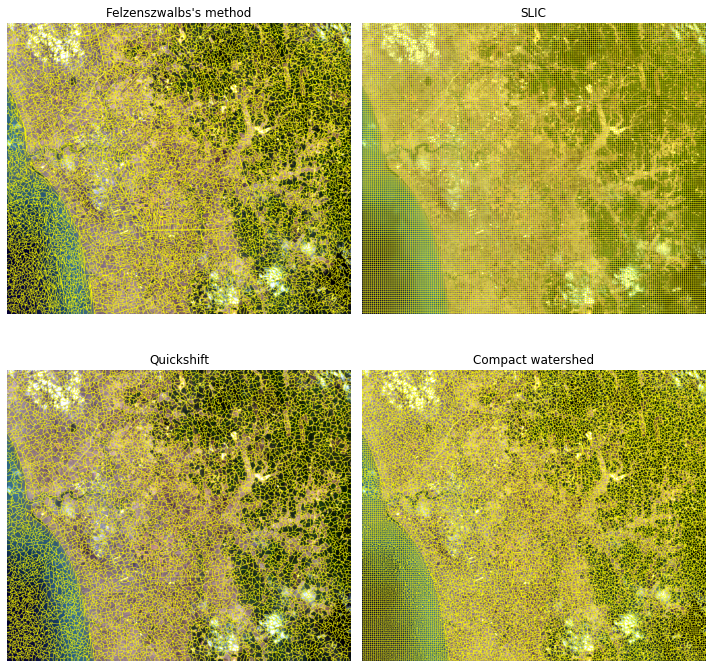

In [ ]:
'''  ======= Segmentation  ========= '''
# credits: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html

img = inputData[:, :, bands]

segments_fz = felzenszwalb(img, scale=1, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=30000, compactness=10, convert2lab=False)
segments_quick = quickshift(img, kernel_size=2, max_dist=6, ratio=0.5, convert2lab=False)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=30000, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
print(f"Watershed number of segments: {len(np.unique(segments_watershed))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img[:, :, [2,1,0]], segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img[:, :, [2,1,0]], segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img[:, :, [2,1,0]], segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img[:, :, [2,1,0]], segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

plt.imsave(rootPath + dataName + "_fz_seg.png", mark_boundaries(img[:, :, [2,1,0]], segments_fz, color=(0.8, 0, 0)))
plt.imsave(rootPath + dataName + "_slic_seg.png", mark_boundaries(img[:, :, [2,1,0]], segments_slic, color=(0.8, 0, 0)))
plt.imsave(rootPath + dataName + "_quick_seg.png", mark_boundaries(img[:, :, [2,1,0]], segments_quick, color=(0.8, 0, 0)))
plt.imsave(rootPath + dataName + "_watershed_seg.png", mark_boundaries(img[:, :, [2,1,0]], segments_watershed, color=(0.8, 0, 0)))

In [ ]:
'''  =========== Get spectral properties of segments ==============  '''
# modified from https://opensourceoptions.com/blog/python-geographic-object-based-image-analysis-geobia/

# pick the best segment
segments = segments_fz # segments_fz, segments_slic, segments_quick, segments_watershed
split_ROI = False

# calculate spectral properties to train our model with
def segment_features(segment_pixels):
    features = []
    npixels, numBands = segment_pixels.shape
    for b in range(numBands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        print(stats)
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            band_stats[3] = 0.0
        features += band_stats
    return features

# apply properties to objects
segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

print('created', len(objects), 'objects with', len(objects[0]), 'variables')

Streaming output truncated to the last 5000 lines.
DescribeResult(nobs=151, minmax=(0.22011709221011547, 0.7562205236623841), mean=0.4606817024035567, variance=0.013678865109694816, skewness=0.2525274154016048, kurtosis=-0.5269829054351445)
DescribeResult(nobs=187, minmax=(0.06490819756917507, 0.3247995862425653), mean=0.1077829820128912, variance=0.0011463184547350939, skewness=2.818535777320776, kurtosis=11.924541844044716)
DescribeResult(nobs=187, minmax=(0.08922866271109083, 0.43655864901871294), mean=0.14534422540436448, variance=0.0019766257018197135, skewness=3.0550984181798007, kurtosis=14.221987483686227)
DescribeResult(nobs=187, minmax=(0.0541863881181655, 0.45552472661987925), mean=0.10666559604241417, variance=0.0030724504226061983, skewness=3.4241276635557725, kurtosis=14.870470211426369)
DescribeResult(nobs=187, minmax=(0.6979539011463084, 1.0), mean=0.8274489810042771, variance=0.0036766185581759802, skewness=0.519404424946475, kurtosis=-0.008789426244563359)
DescribeRes

In [ ]:
''' =========== Split Training and Testing Data ======= '''
if split_ROI:
    # Read shapefile to geopandas geodataframe
    gdf = gpd.read_file(rootPath + "ROI/" + ROI)

    # Get names of land cover classes/labels
    class_names = gdf['label'].unique()
    print('class names', class_names)

    # Create a unique id (integer) for each land cover class/label
    class_ids = np.arange(class_names.size) + 1
    print('class ids', class_ids)

    # Create a pandas data frame of the labels and ids and save to csv
    df = pd.DataFrame({'label': class_names, 'id': class_ids})
    df.to_csv(rootPath + "ROI/" + 'class_lookup.csv')
    print('gdf without ids', gdf.head())

    # add a new column to geodatafame with the id for each class/label
    gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))
    print('gdf with ids', gdf.head())
    
    # split the truth data into training and test data sets and save each to a new shapefile
    gdf_train = gdf.sample(frac=0.8)
    gdf_test = gdf.drop(gdf_train.index)
    print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test', gdf_test.shape)
    gdf_train.to_file(rootPath + "ROI/" + 'train.shp')
    gdf_test.to_file(rootPath + "ROI/" + 'test.shp')

# set path to training data
trainFS = rootPath + "ROI/" + 'train.shp'
trainDS = ogr.Open(trainFS)
trainLyr = trainDS.GetLayer()

# set path to testing data
testFS = rootPath + "ROI/" + 'test.shp'
testDS = ogr.Open(testFS)
testLyr = testDS.GetLayer()

In [ ]:
'''  =========== Rasterize Training Data with Segments ===========  '''
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', inputDS.RasterXSize, inputDS.RasterYSize, gdal.GDT_UInt16)
target_ds.SetGeoTransform(inputDS.GetGeoTransform())
target_ds.SetProjection(inputDS.GetProjection())

# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], trainLyr, options=options)

# retrieve the rasterized data
ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# get unique LULC classes we created in QGIS
classes = np.unique(ground_truth)[1:]
print('class values', classes)

# segments representing each LULC class
segments_per_class = {}
  
# find which segment belong to which class
for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
    print("Training segments for class", klass, ":", len(segments_of_class))

# make sure no segment represents more than one class
intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments

assert len(intersection) == 0, "Segment(s) represent multiple classes"

class values [1 2 3 4 5]
Training segments for class 1 : 42
Training segments for class 2 : 41
Training segments for class 3 : 46
Training segments for class 4 : 43
Training segments for class 5 : 24


In [ ]:
''' ============= Training Data ============= '''
# copy segments
train_img = np.copy(segments)

# set a threshold
threshold = train_img.max() + 1
    
# find segments associated with class
for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

# rid of data less than threshold
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

training_objects = []
training_labels = []

# separate objects into LULC class groups
for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
    print('Training objects for class', klass, ':', len(class_train_object))

Training objects for class 1 : 38
Training objects for class 2 : 38
Training objects for class 3 : 46
Training objects for class 4 : 40
Training objects for class 5 : 23


In [ ]:
''' ========== Classification =============== '''
# Fitting Random Forest Classifier
if run_RF:
    print('Fitting Random Forest Classifier')

    start = perf_counter()
    classifier_RF = RandomForestClassifier(n_jobs=-1)
    classifier_RF.fit(training_objects, training_labels)

    time_elapsed = perf_counter() - start
    print("Random Forest Time Elapsed: ", time_elapsed, " seconds.")

# Fitting Decision Tree Classifier
if run_DT:
    print('Fitting Decision Tree Classifier')

    start = perf_counter()
    classifier_DT = tree.DecisionTreeClassifier()
    classifier_DT.fit(training_objects, training_labels)

    time_elapsed = perf_counter() - start
    print("Decision Tree Time Elapsed: ", time_elapsed, " seconds.")

# Fitting SVM Classifier
if run_SVM:
    print('Fitting SVM Classifier')

    start = perf_counter()
    classifier_SVM = svm.SVC()
    classifier_SVM.fit(training_objects, training_labels)

    time_elapsed = perf_counter() - start
    print("SVM Time Elapsed: ", time_elapsed, " seconds.")

# Fitting NN Classifier
if run_NN:
    train_x = np.asarray(training_objects)
    train_y = np.asarray(training_labels)
    print('Fitting NN Classifier')

    start = perf_counter()
    classifier_NN = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(nn_layers, activation='softmax')
    ])

    classifier_NN.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy']
                  )

    history = classifier_NN.fit(train_x, train_y, epochs=50)

    time_elapsed = perf_counter() - start
    print("NN Time Elapsed: ", time_elapsed, " seconds.")

Fitting Random Forest Classifier
Random Forest Time Elapsed:  0.2412554560000899  seconds.
Fitting Decision Tree Classifier
Decision Tree Time Elapsed:  0.005190410000068368  seconds.
Fitting SVM Classifier
SVM Time Elapsed:  0.006901480000124138  seconds.
Fitting NN Classifier
Epoch 1/50
6/6 [==============================] - 1s 4ms/step - loss: 1.7011 - accuracy: 0.3517
Epoch 2/50
6/6 [==============================] - 0s 2ms/step - loss: 1.6279 - accuracy: 0.3998
Epoch 3/50
6/6 [==============================] - 0s 3ms/step - loss: 1.5347 - accuracy: 0.4258
Epoch 4/50
6/6 [==============================] - 0s 2ms/step - loss: 1.4487 - accuracy: 0.4436
Epoch 5/50
6/6 [==============================] - 0s 2ms/step - loss: 1.4059 - accuracy: 0.5005
Epoch 6/50
6/6 [==============================] - 0s 2ms/step - loss: 1.3017 - accuracy: 0.5174
Epoch 7/50
6/6 [==============================] - 0s 2ms/step - loss: 1.2461 - accuracy: 0.5798
Epoch 8/50
6/6 [==============================] -

In [ ]:
''' ========== Prediction =============== '''
# Predicting with Random Forest Classifier
if run_RF:
    print('Predicting with Random Forest')
    start = perf_counter()
    predicted_RF = classifier_RF.predict(objects)

    time_elapsed = perf_counter() - start
    print("RF Time Elapsed: {:.2f} seconds".format(time_elapsed))

# Predicting with Decision Tree
if run_DT:
    print('Predicting with Decision Tree')
    start = perf_counter()
    predicted_DT = classifier_DT.predict(objects)
        
    time_elapsed = perf_counter() - start
    print("DT Time Elapsed: {:.2f} seconds".format(time_elapsed))

# Predicting with SVM
if run_SVM:
    print('Predicting with SVM')
    start = perf_counter()
    predicted_SVM = classifier_SVM.predict(objects)
        
    time_elapsed = perf_counter() - start
    print("SVM Time Elapsed: {:.2f} seconds".format(time_elapsed))

# Predicting with NN
if run_NN:
    print('Predicting with NN')
    predObjects = np.asarray(objects)

    start = perf_counter()
    predicted_NN = classifier_NN.predict(predObjects)
        
    time_elapsed = perf_counter() - start
    print("NN Time Elapsed: {:.2f} seconds".format(time_elapsed))

print('Done!')

Predicting with Random Forest
RF Time Elapsed: 0.15 seconds
Predicting with Decision Tree
DT Time Elapsed: 0.04 seconds
Predicting with SVM
SVM Time Elapsed: 0.15 seconds
Predicting with NN
NN Time Elapsed: 0.28 seconds
Done!


In [ ]:
''' ========== Applying Prediction =============== '''
# set an image boundary
mask = np.sum(img, axis=2)
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0

# apply Random Forest prediction
if run_RF:
    print('Applying RF Prediction to NumPy Array')
    clf_RF = np.copy(segments)
    for segment_id, klass in zip(segment_ids, predicted_RF):
        clf_RF[clf_RF == segment_id] = klass

    clf_RF = np.multiply(clf_RF, mask)
    clf_RF[clf_RF < 0] = 0

# apply Decision Tree prediction
if run_DT:
    print('Applying DT Prediction to NumPy Array')
    clf_DT = np.copy(segments)
    for segment_id, klass in zip(segment_ids, predicted_DT):
        clf_DT[clf_DT == segment_id] = klass

    clf_DT = np.multiply(clf_DT, mask)
    clf_DT[clf_DT < 0] = 0

# apply SVM prediction
if run_SVM:
    print('Applying SVM Prediction to NumPy Array')
    clf_SVM = np.copy(segments)
    for segment_id, klass in zip(segment_ids, predicted_SVM):
        clf_SVM[clf_SVM == segment_id] = klass

    clf_SVM = np.multiply(clf_SVM, mask)
    clf_SVM[clf_SVM < 0] = 0

# apply NN prediction
if run_NN:
    print('Applying NN Prediction to NumPy Array')
    predLabels = np.argmax(predicted_NN[:,1:nn_layers], axis=1) + 1
    clf_NN = np.copy(segments)
    for spLabel in np.unique(predLabels):
        a = np.where(predLabels == spLabel)[0]
        clf_NN[np.isin(segments, a)] = spLabel
        
    '''
    print(predicted_NN[:,1:5].shape)
    print(np.unique(predLabels))
    print("1: {}".format(len(np.where(predLabels == 1)[0])))
    print("2: {}".format(len(np.where(predLabels == 2)[0])))
    print("3: {}".format(len(np.where(predLabels == 3)[0])))
    print("4: {}".format(len(np.where(predLabels == 4)[0])))
    '''

print('Done!')

Applying RF Prediction to NumPy Array
Applying DT Prediction to NumPy Array
Applying SVM Prediction to NumPy Array
Applying NN Prediction to NumPy Array
Done!


In [ ]:
''' ========== Saving Prediction =============== '''
# Save Random Forest classification into GeoTIFF image
if run_RF:
    print('Saving RF classificaiton to raster with gdal')
    clfds_RF = driverTiff.Create(rootPath + 'classified_' + dataName + '_RF.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_RF.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_RF.SetProjection(inputDS.GetProjection())
    clfds_RF.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_RF.GetRasterBand(1).WriteArray(clf_RF)
    clfds_RF = None

# Save Decision Tree classification into GeoTIFF image
if run_DT:
    print('Saving DT classificaiton to raster with gdal')
    clfds_DT = driverTiff.Create(rootPath + 'classified_' + dataName + '_DT.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_DT.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_DT.SetProjection(inputDS.GetProjection())
    clfds_DT.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_DT.GetRasterBand(1).WriteArray(clf_DT)
    clfds_DT = None

# Save SVM classification into GeoTIFF image
if run_SVM:
    print('Saving SVM classificaiton to raster with gdal')
    clfds_SVM = driverTiff.Create(rootPath + 'classified_' + dataName + '_SVM.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_SVM.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_SVM.SetProjection(inputDS.GetProjection())
    clfds_SVM.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_SVM.GetRasterBand(1).WriteArray(clf_SVM)
    clfds_SVM = None

# Save NN classification into GeoTIFF image
if run_NN:
    print('Saving NN classificaiton to raster with gdal')
    clfds_NN = driverTiff.Create(rootPath + 'classified_' + dataName + '_NN.tif', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_Float32)
    clfds_NN.SetGeoTransform(inputDS.GetGeoTransform())
    clfds_NN.SetProjection(inputDS.GetProjection())
    clfds_NN.GetRasterBand(1).SetNoDataValue(-9999.0)
    clfds_NN.GetRasterBand(1).WriteArray(clf_NN)
    clfds_NN = None

print('Done!')

Saving RF classificaiton to raster with gdal
Saving DT classificaiton to raster with gdal
Saving SVM classificaiton to raster with gdal
Saving NN classificaiton to raster with gdal
Done!


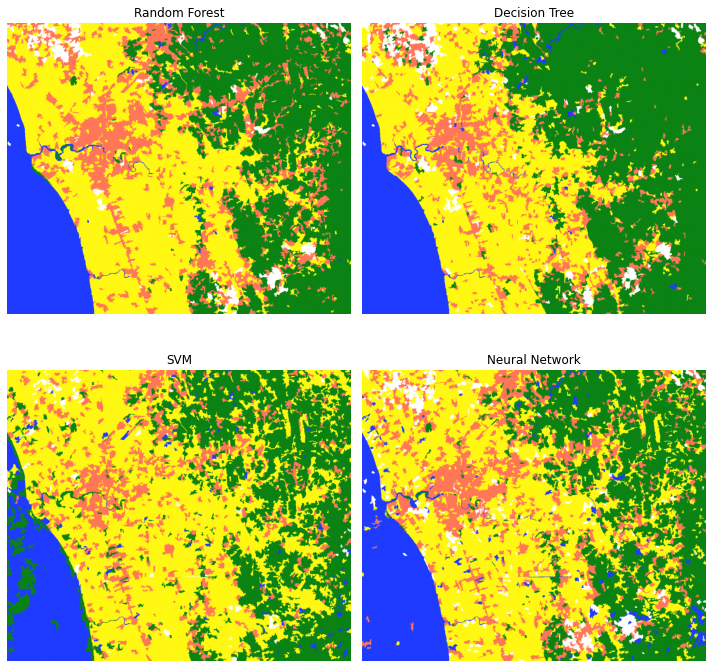

In [ ]:
''' ============ Display ========== '''
# converts LULC class to RGB
def toRGB(z):
    rgb = np.zeros((z.shape[0], z.shape[1], 3))
    rgb[np.where(z == 1)] = [31, 59, 255]  # blue
    rgb[np.where(z == 2)] = [255, 119, 88]  # red
    rgb[np.where(z == 3)] = [255, 248, 18]  # yellow
    rgb[np.where(z == 4)] = [11, 131, 20]  # green
    rgb[np.where(z == 5)] = [255, 255, 255]  # white
    return rgb / 255

# create a plot to display images
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# convert Random Forest image to RGB and save as png
if run_RF:
    predMapRGB_RF = toRGB(clf_RF)
    plt.imsave(rootPath + dataName + "_RF.png", predMapRGB_RF)

    ax[0, 0].imshow(predMapRGB_RF)
    ax[0, 0].set_title("Random Forest")

# convert Decision Tree image to RGB and save as png
if run_DT:
    predMapRGB_DT = toRGB(clf_DT)
    plt.imsave(rootPath + dataName + "_DT.png", predMapRGB_DT)
    
    ax[0, 1].imshow(predMapRGB_DT)
    ax[0, 1].set_title('Decision Tree')

# convert SVM image to RGB and save as png
if run_SVM:
    predMapRGB_SVM = toRGB(clf_SVM)
    plt.imsave(rootPath + dataName + "_SVM.png", predMapRGB_SVM)

    ax[1, 0].imshow(predMapRGB_SVM)
    ax[1, 0].set_title('SVM')

# convert NN image to RGB and save as png
if run_NN:
    predMapRGB_NN = toRGB(clf_NN)
    plt.imsave(rootPath + dataName + "_NN.png", predMapRGB_NN)

    ax[1, 1].imshow(predMapRGB_NN)
    ax[1, 1].set_title('Neural Network')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
''' ====== Accuracy ======= '''
# retrieve testing data
driver = gdal.GetDriverByName('MEM')
targetDS = driver.Create('', inputDS.RasterXSize, inputDS.RasterYSize, 1, gdal.GDT_UInt16)
targetDS.SetGeoTransform(inputDS.GetGeoTransform())
targetDS.SetProjection(inputDS.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(targetDS, [1], testLyr, options=options)

truth = targetDS.GetRasterBand(1).ReadAsArray()
idx = np.nonzero(truth)

# Random Forest accuracy
if run_RF:
    predDS_RF = gdal.Open(rootPath + 'classified_' + dataName + '_RF.tif')
    pred_RF = predDS_RF.GetRasterBand(1).ReadAsArray()
    
    cm_rf = metrics.confusion_matrix(truth[idx], pred_RF[idx])
    acc_rf = cm_rf.diagonal() / cm_rf.sum(axis=0)

    tp_rf = np.diag(cm_rf)
    prec_rf = list(map(truediv, tp_rf, np.sum(cm_rf, axis=0)))
    rec_rf = list(map(truediv, tp_rf, np.sum(cm_rf, axis=1)))

    print('Random Forest:', '\nAccuracy: ', mean(acc_rf))
    print('Precision: ', mean(prec_rf), '\nRecall: ', mean(rec_rf))

# Decision Tree accuracy
if run_DT:
    predDS_DT = gdal.Open(rootPath + 'classified_' + dataName + '_DT.tif')
    pred_DT = predDS_DT.GetRasterBand(1).ReadAsArray()
    
    cm_dt = metrics.confusion_matrix(truth[idx], pred_DT[idx])
    acc_dt = cm_dt.diagonal() / cm_dt.sum(axis=0)

    tp_dt = np.diag(cm_dt)
    prec_dt = list(map(truediv, tp_dt, np.sum(cm_dt, axis=0)))
    rec_dt = list(map(truediv, tp_dt, np.sum(cm_dt, axis=1)))

    print('\nDecision Tree:', '\nAccuracy: ', mean(acc_dt))
    print('Precision: ', mean(prec_dt), '\nRecall: ', mean(rec_dt))

# SVM accuracy
if run_SVM:
    predDS_SVM = gdal.Open(rootPath + 'classified_' + dataName + '_SVM.tif')
    pred_SVM = predDS_SVM.GetRasterBand(1).ReadAsArray()
    
    cm_svm = metrics.confusion_matrix(truth[idx], pred_SVM[idx])
    acc_svm = cm_svm.diagonal() / cm_svm.sum(axis=0)

    tp_svm = np.diag(cm_svm)
    prec_svm = list(map(truediv, tp_svm, np.sum(cm_svm, axis=0)))
    rec_svm = list(map(truediv, tp_svm, np.sum(cm_svm, axis=1)))

    print('\nSupport Vector Machine:', '\nAccuracy: ', mean(acc_svm))
    print('Precision: ', mean(prec_svm), '\nRecall: ', mean(rec_svm))

# NN accuracy
if run_NN:
    predDS_NN = gdal.Open(rootPath + 'classified_' + dataName + '_NN.tif')
    pred_NN = predDS_NN.GetRasterBand(1).ReadAsArray()

    cm_nn = metrics.confusion_matrix(truth[idx], pred_NN[idx])
    acc_nn = cm_nn.diagonal() / cm_nn.sum(axis=0)

    tp_nn = np.diag(cm_nn)
    prec_nn = list(map(truediv, tp_nn, np.sum(cm_nn, axis=0)))
    rec_nn = list(map(truediv, tp_nn, np.sum(cm_nn, axis=1)))

    print('\nNeural Network:', '\nAccuracy: ', mean(acc_nn))
    print('Precision: ', mean(prec_nn), '\nRecall: ', mean(rec_nn))

total_time = perf_counter() - prog_start
print("\nTotal Time Elapsed: {:.2f} seconds".format(total_time))

Random Forest: 
Accuracy:  0.9723809523809523
Precision:  0.9723809523809523 
Recall:  0.9523809523809524

Decision Tree: 
Accuracy:  0.8773737373737374
Precision:  0.8773737373737374 
Recall:  0.8952380952380953

Support Vector Machine: 
Accuracy:  0.8163636363636364
Precision:  0.8163636363636364 
Recall:  0.6583333333333333

Neural Network: 
Accuracy:  0.9244444444444444
Precision:  0.9244444444444444 
Recall:  0.9142857142857143

Total Time Elapsed: 197.55 seconds
